## 9)

$e_k = x^{k - 1}$, поэтому несложно посчитать скалярное произведение:

$$\langle e_i, e_j \rangle = \int\limits_{0}^{1}x^{i + j - 2}dx = \frac{1}{i + j - 1}$$

Отсюда, найдем матрицу Грама (Гильберта).

In [4]:
import numpy as np

def get_matrix(n):
    ns = range(1, n + 1)
    matrix = []
    for i in ns:
        matrix.append([])
        for j in ns:
            matrix[-1].append(1.0 / (i + j - 1))
    return np.array(matrix)

In [5]:
get_matrix(5)

array([[1.        , 0.5       , 0.33333333, 0.25      , 0.2       ],
       [0.5       , 0.33333333, 0.25      , 0.2       , 0.16666667],
       [0.33333333, 0.25      , 0.2       , 0.16666667, 0.14285714],
       [0.25      , 0.2       , 0.16666667, 0.14285714, 0.125     ],
       [0.2       , 0.16666667, 0.14285714, 0.125     , 0.11111111]])

Классическая функция для построения графиков:

In [6]:
import matplotlib.pyplot as plt

def build_plot(xs, ys, xlabel='', ylabel='', title='', filename='plot', 
               plot_labels=None, color_shapes=None, points=None):
    xs = np.array(xs)
    ys = np.array(ys)
    if xs.ndim == 1:
        xs = np.array([xs])
        ys = np.array([ys])
    if color_shapes is None:
        color_shapes = ['' for _ in range(xs.shape[0] if xs.ndim > 1 else 1)]
    
    plt.clf()
    if points is not None:
        plt.plot(points[0], points[1], 'ro')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    for ind, (x, y) in enumerate(zip(xs, ys)):
        if plot_labels is not None:
            plt.plot(x, y, color_shapes[ind], label=plot_labels[ind])
        else:
            plt.plot(x, y, color_shapes[ind])
    if plot_labels is not None:
        plt.legend()
    plt.show()

Реализаем функцию для вычисления скалярного произведения двух векторов в нашем базисе.

In [7]:
def dot_product(first, second):
    n = first.shape[0]
    A = get_matrix(n)
    ans = 0
    for i, f in enumerate(first):
        for j, s in enumerate(second):
            ans += f * s * A[i][j]
    return ans

In [8]:
dot_product(np.array([1.0, 1.0]), np.array([1.0, 1.0]))

2.3333333333333335

In [73]:
def get_max_eigenvalue(n, iters_num=1000):
    u = np.array([1.0 / np.sqrt(n) for _ in range(n)])
    A = get_matrix(n)
    prev_u = np.zeros(n)
    
    for iter_num in range(iters_num):
        norm = np.linalg.norm(u)
        if norm > 10**9:
            u = u / norm
        prev_u = u.copy()
        u = np.dot(A, u)
    
    return dot_product(u, prev_u) / dot_product(prev_u, prev_u)

Сравним получаенное значение со значением, которое умеет находить `numpy.linalg`

In [10]:
from numpy import linalg as linalg

N = 5

values, _ = linalg.eig(get_matrix(N))
values.sort()
print(get_max_eigenvalue(N), values[-1])

1.567050691098231 1.56705069109823


Построим график зависимости погрешности от числа итераций для $N = 10$ (тут мы возьмем значение из `np.linalg` за эталон, хотя это не посчитанное аналитически значение. Просто предположив, что оно вычисленно достаточно точно, и посмотрим на скорось сходимости):

[1.09325101e-13 2.26674535e-11 2.14743883e-09 1.22896774e-07
 4.72968929e-06 1.28749614e-04 2.53089077e-03 3.57418163e-02
 3.42929548e-01 1.75191967e+00]


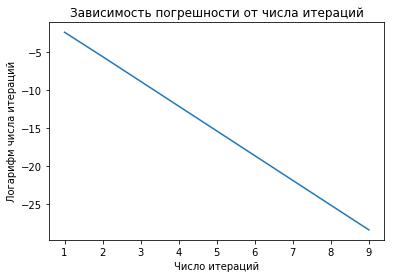

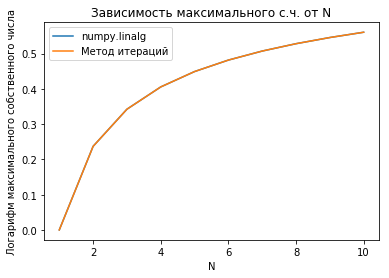

In [58]:
from numpy import linalg as linalg

N = 10

values, _ = linalg.eig(get_matrix(N))
values.sort()
print(values)

iter_nums = range(1, 10)

build_plot(iter_nums, [np.log(np.abs(values[-1] - get_max_eigenvalue(N, iter_num))) for iter_num in iter_nums], 
           'Число итераций',
           'Логарифм числа итераций',
           'Зависимость погрешности от числа итераций')


ns = range(1, 11)
values = []
for n in ns:
    value = linalg.eig(get_matrix(n))[0]
    value.sort()
    values.append(value[-1])

build_plot([ns, ns], [np.log(values), [np.log(get_max_eigenvalue(n)) for n in ns]], 
           'N',
           'Логарифм максимального собственного числа',
           'Зависимость максимального с.ч. от N',
           plot_labels=['numpy.linalg', 'Метод итераций'])

В данном случае мы очень быстро получаем очень маленькую погрешность (экспоненциально убывающую). Это соответствует теоретической оценке $\mathcal{O}(\frac{\lambda_{p + 1}}{\lambda_1})$, в данном случае это частное очень, так что быстрая сходимость ожидаема. И значение мы находим примерно такое же, как и `np.linalg`

Далее будем искать минимальное собственное число. Мы знаем, что наша матрица Грама симметричная.

In [75]:
def get_min_eigenvalue(n, iters_num=50000, alpha=None):
    alpha = get_max_eigenvalue(n, iters_num) + 10**(-6) if alpha is None else alpha
    u = np.array([1.0 / np.sqrt(n) for _ in range(n)])
    A = get_matrix(n) - alpha * np.identity(n)
    prev_u = np.zeros(n)
    
    for iter_num in range(iters_num):
        norm = np.linalg.norm(u)
        if norm > 10**9:
            u = u / norm
        prev_u = u.copy()
        u = np.dot(A, u)
    
    return dot_product(u, prev_u) / dot_product(prev_u, prev_u) + alpha

In [47]:
N = 3

values, _ = linalg.eig(get_matrix(N))
values.sort()
print(get_min_eigenvalue(N), values[0])

0.0026873403557670095 0.0026873403557735338


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


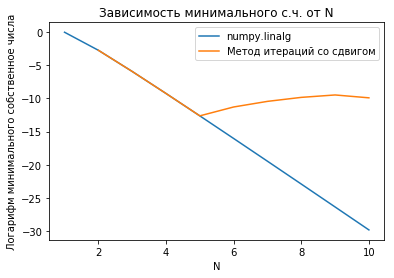

In [76]:
from numpy import linalg as linalg

ns = range(1, 11)
values = []
for n in ns:
    value = linalg.eig(get_matrix(n))[0]
    value.sort()
    values.append(value[0])

build_plot([ns, ns], [np.log(values), [np.log(get_min_eigenvalue(n)) for n in ns]], 
           'N',
           'Логарифм минимального собственное числа',
           'Зависимость минимального с.ч. от N',
           plot_labels=['numpy.linalg', 'Метод итераций со сдвигом'])

Как видно на графике, уже при $N = 6$ наше значение существено отличается от значения `numpy.linalg`. Это соотстветствует тому, что обсуждалось на леции. При этом зависимость согласно `numpy.linalg` обратно экспоненциональная. В нашем же случае увеличение числа итераций не поможет. При других $\alpha$ даже при наличии сходимости, попасть в другое с.ч. не вышло.

Теперь найдем зависимость $\kappa(N)$. Строим график:

In [50]:
def get_kappa(N):
    return get_max_eigenvalue(N) / get_min_eigenvalue(N)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


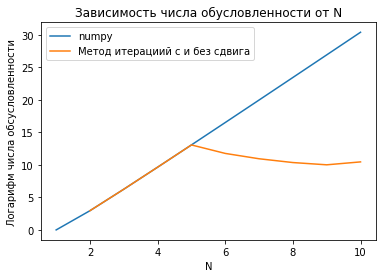

In [54]:
from numpy import linalg as linalg

ns = range(1, 11)
values = [np.linalg.cond(get_matrix(n)) for n in ns]

build_plot([ns, ns], [np.log(values), [np.log(get_kappa(n)) for n in ns]], 
           'N',
           'Логарифм числа обсусловленности',
           'Зависимость числа обусловленности от N',
           plot_labels=['numpy', 'Метод итерациий с и без сдвига'])

Видим опять таки рассхождение с $N = 5$ (ожидаемо, ведь максимальные с.ч. у нас примерно такие же, как и в `numpy.linalg`, а минимальные различаются с $N = 6$).

Судя по графику значений из `numpy`, мы полуаем экспоненциальную зависимость (т.к. логарифм прямая). Ивестно значение числа обусловленности матрицы Гильберта $\mathcal{O}\bigg(\frac{(1 + \sqrt{2})^{4n}}{\sqrt{n}}\bigg)$

Теперь посмотрим на метод Эйткена.

In [164]:
def one_iter(A, u):
    if np.linalg.norm(u) > 10**9:
        u = u / np.linalg.norm(u)
    return np.dot(A, u)

def get_ans(f, s, t):
    divider = f + t - 2 * s
    if divider == 0:
        return None
    return t - (t - s) ** 2 / divider

def init(u, A):
    first = u.copy()
    second = np.dot(A, first)
    third = np.dot(A, second)
    ans_first = dot_product(second, first) / dot_product(first, first)
    ans_second = dot_product(third, second) / dot_product(second, second)
    ans_third = dot_product(one_iter(A, third), third) / dot_product(third, third)
    return ans_first, ans_second, ans_third, third

    
def get_min_eigenvalue_eitken(n, iters_num=50000, alpha=None):
    alpha = get_max_eigenvalue(n, iters_num) + 10**(-3) if alpha is None else alpha
    u = np.array([1.0 / np.sqrt(n) for _ in range(n)])
    A = get_matrix(n) - alpha * np.identity(n)
    ans_first, ans_second, ans_third, third = init(u, A)
    
    ans = get_ans(ans_first, ans_second, ans_third)
    for _ in range(iters_num):
        third = one_iter(A, third)
        
        ans_first = ans_second
        ans_second = ans_third
        ans_third = dot_product(one_iter(A, third), third) / dot_product(third, third)
        
        result = get_ans(ans_first, ans_second, ans_third)
        ans = ans if result is None else result
    
    return ans + alpha

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in double_scalars


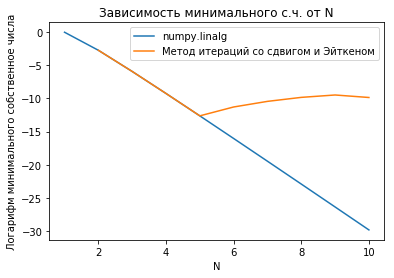

In [165]:
from numpy import linalg as linalg

ns = range(1, 11)
values = []
for n in ns:
    value = linalg.eig(get_matrix(n))[0]
    value.sort()
    values.append(value[0])

build_plot([ns, ns], [np.log(values), [np.log(get_min_eigenvalue_eitken(n)) for n in ns]], 
           'N',
           'Логарифм минимального собственное числа',
           'Зависимость минимального с.ч. от N',
           plot_labels=['numpy.linalg', 'Метод итераций со сдвигом и Эйткеном'])

У меня лично Эйткен не дал особых улчушений, не знаю почему. Тем не менее мы еще раз столкнулись с проблемами сходимости, о которых говорили.